# Modelowanie cen mieszkań na rynku warszawskim
## Główny cel projektu: opracowanie modelu szacującego ceny mieszkań (w PLN) na rynku warszawskim.

### Założenia:
> Algorytmy użyte w procesie modelowania to:
- Linear regression,
- Decision tree regressor,
- Random forest regressor.

> Zmienne objaśniające:
- Powierzchnia mieszkania (m²),
- Dzielnica,
- Piętro.

> Metryka wydajności modeli:
- Pierwiastek błędu średniokwadratowego (RMSE).
<br>

### Zbiór danych:
Ceny mieszkań na rynku warszawskim zebrane z jednego z wiodących portali ogłoszeniowych przy pomocy własnego skryptu opartego na webscrapingu (link do skryptu: [Ceny mieszkań](https://github.com/Daro84/flat-prices )).<br>


### 1. Import bibliotek użytych w projekcie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from scipy.stats import randint

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 2. Wczytanie danych

In [3]:
prices = pd.read_excel('prices_Warsaw.xlsx')

<b>Podgląd wstępnego zbioru danych</b>

In [4]:
prices.head()

,district,area,floor,price
0,Warszawa,41.50,1,715000
1,Mokotów,168.50,0,2948750
2,Bemowo,103.36,3,764864
3,Śródmieście,64.00,4,750000
4,Praga-Południe,61.00,2,499000


<b>Typy zmiennych</b>

In [5]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5827 entries, 0 to 5826
Data columns (total 4 columns):
district    5827 non-null object
area        5827 non-null float64
floor       5827 non-null int64
price       5827 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 227.6+ KB


<b>Statystyki opisowe dla zmiennych numerycznych</b>

In [6]:
prices.describe()

,area,floor,price
count,5827.000000,5827.000000,5.827000e+03
mean,71.500431,3.139351,7.614946e+05
std,35.466640,3.424103,6.007674e+05
min,11.200000,0.000000,2.000000e+04
25%,48.335000,1.000000,4.490000e+05
50%,62.000000,2.000000,5.750000e+05
75%,85.000000,4.000000,8.550000e+05
max,423.600000,127.000000,8.600000e+06


### 3. Przygotowanie danych do modelowania

<b>Zmienna zależna - 'price'</b><br><br>
Usunięcie wartości zmiennej 'price' przekraczających 95 percentyl. Z analizy wyłączone są najdroższe mieszkania na rynku, bowiem specyfika kształtowania się ich cen jest odmienna.


In [7]:
upper_bound = prices['price'].quantile(0.95)
num_outliers = (prices['price'] > upper_bound).sum()
prices = prices[prices['price'] < upper_bound]
print('Mieszkania z ceną powyżej {} PLN zostają wyłączone z analizy - w sumie {} mieszkań.'
      .format(round(upper_bound,2), num_outliers))

Mieszkania z ceną powyżej 1750000.0 PLN zostają wyłączone z analizy - w sumie 287 mieszkań.


Sprawdzenie poprawności wartości zmiennej 'price' poprzez weryfikację cen za m² - mieszkania z ceną poniżej 3 tys. PLN/m² zostają uznane za błędne i usunięte ze zbioru danych.<br>

In [8]:
prices['price_m'] = prices['price'] / prices['area']
prices['price_m'].sort_values().head()

1706     982.800983
1912    2487.500000
5611    2516.129032
2156    2977.611940
3973    3934.426230
Name: price_m, dtype: float64

In [9]:
prices = prices[prices['price_m'] >=3000]

Zrekodowanie zmiennej 'price' dla zwiększenia czytelności - wartości w tys. PLN

In [10]:
prices['price'] = prices['price'] / 1000

<b>Zmienna 'floor'</b><br><br>
Usunięcie odstających i błędnych wartości zmiennej - w analizie uwzględniono tylko wartości do 20 piętra włącznie.

In [11]:
prices['floor'].sort_values(ascending=False).head()

3322    127
4369     28
477      20
3383     20
323      19
Name: floor, dtype: int64

In [12]:
prices = prices[prices['floor'] <= 20]

<b>Zmienna 'district'</b><br>

Rekodowanie zmiennej 'district'<br>
Zbiór danych wejściowych zaczerpniętych poprzez scrapowanie strony www z ofertami zawiera chaotyczny podział na dzielnice, uwzględniający zarówno nazwy dzielnic jak i nazwy poszczgólnych osiedli, jak też dane nieprecyzyjne (np. "Warszawa" lub "Polska"), co w sumie stanowi aż 129 kategorii. Poniższa funkcja lambda w połączeniu z dictionary porządkuje zmienną 'district', wprowadzając podział na 18 głównych dzielnic. Nazwy nieprecyzyjne zostają usunięte ze zbioru.

In [13]:
district_dict = {'Anin':'Wawer', 'Augustówka':'Mokotów', 'Bemowo Lotnisko':'Bemowo', 'BiałołękaDworska':'Białołęka', 
'BłoniaWilanowskie':'Wilanów', 'Bródno':'Targówek', 'Brzeziny':'Białołęka', 'Chomiczówka':'Bielany',
'Chrzanów':'Bemowo', 'Czechowice':'Ursus', 'Czerniaków':'Mokotów', 'Czyste': 'Wola', 'Elsnerów':'Targówek',
'Filtry':'Ochota', 'Fort Bema':'Bemowo', 'Gocław':'Praga-Południe', 'Gocławek':'Praga-Południe',
'Gołąbki':'Ursus', 'Górce':'Bemowo', 'Grabów':'Ursynów', 'Grochów':'Praga-Południe', 'Grodzisk':'Białołęka',
'Henryków':'Białołęka', 'JelonkiPołudniowe':'Bemowo', 'JelonkiPółnocne':'Bemowo', 'Józefosław':'Ursynów',
'Kabaty':'Ursynów', 'Kamionek':'Praga-Południe', 'Kobiałka':'Białołęka', 'Koło':'Wola',
'Ksawerów':'Mokotów', 'Las Bielański':'Bielany', 'Marymont-Kaskada':'Bielany', 'Marymont-Potok':'Bielany',
'Marymont-Ruda':'Bielany', 'Marysin Wawerski ':'Wawer', 'Miedzeszyn':'Wawer', 'Międzylesie':'Wawer',
'Mirów':'Wola', 'Młociny':'Bielany', 'Młynów':'Wola', 'Muranów':'Śródmieście', 'Natolin':'Ursynów',
'Niedźwiadek':'Ursus', 'Nowa Praga':'Praga-Północ', 'Nowe Miasto':'Śródmieście', 'Nowodwory':'Białołęka',
'Białołęka':'Białołęka', 'Nowolipki':'Wola', 'Nowy Rembertów':'Rembertów', 'Odolany':'Wola', 
'Okęcie':'Włochy', 'OlszynkaGrochowska':'Praga-Południe', 'Pelcowizna':'Praga-Północ', 'Piaski':'Bielany',
'Powązki':'Wola', 'Powiśle':'Śródmieście', 'Powsin':'Wilanów', 'Pyry':'Ursynów', 'Rakowiec':'Ochota',
'Raków':'Włochy', 'Sadul':'Wawer', 'Sadyba':'Mokotów', 'SadyŻoliborskie':'Żoliborz', 'Salomea':'Włochy',
'Saska Kępa':'Praga-Południe', 'Siekierki':'Mokotów', 'Sielce':'Mokotów', 'Skorosze':'Ursus',
'Słodowiec':'Bielany', 'Służew':'Mokotów', 'Służewiec':'Mokotów', 'Solec':'Śródmieście',
'Stara Miłosna':'Wesoła', 'Stara Ochota':'Ochota', 'Stara Praga':'Praga-Północ', 'Stare Bielany':'Bielany',
'Stare Miasto':'Śródmieście', 'Stare Włochy':'Włochy', 'Stary Imielin':'Ursynów', 'Stary Mokotów':'Mokotów',
'Stary Rembertów':'Rembertów', 'Stary Żoliborz':'Żoliborz', 'Stegny':'Mokotów', 'Szamoty':'Ursus',
'Szczęśliwice':'Ochota', 'Szmulowizna':'Praga-Północ', 'ŚródmieściePołudniowe':'Śródmieście',
'ŚródmieściePółnocne':'Śródmieście', 'Tarchomin':'Białołęka', 'TargówekMieszkaniowy':'Targówek',
'Ujazdów':'Śródmieście', 'Ulrychów':'Wola', 'Ursynów Centrum':'Ursynów', 'UrsynówPółnocny':'Ursynów',
'Wawrzyszew':'Bielany', 'Wierzbno':'Mokotów', 'Wilanów Niski':'Wilanów', 'Wilanów Wysoki':'Wilanów',
'WilanówKrólewski':'Wilanów', 'Wrzeciono':'Bielany', 'Wyczółki':'Ursynów', 'Wyględów':'Mokotów',
'Zacisze':'Targówek', 'Zawady':'Wilanów', 'Zerzeń':'Wawer', 'Zielona-Grzybowa':'Wesoła',
'Żerań':'Białołęka', 'Bemowo':'Bemowo', 'Białołęka':'Białołęka', 'Bielany':'Bielany', 'Mokotów':'Mokotów',
'Ochota':'Ochota', 'Praga-Południe':'Praga-Południe', 'Praga-Północ':'Praga-Północ',
'Rembertów':'Rembertów', 'Śródmieście':'Śródmieście', 'Targówek':'Targówek', 'Ursus':'Ursus',
'Ursynów':'Ursynów', 'Wawer':'Wawer', 'Wesoła':'Wesoła', 'Wilanów':'Wilanów', 'Włochy':'Włochy',
'Wola':'Wola', 'Żoliborz':'Żoliborz'}


prices['district'] = prices['district'].apply(lambda d: d.strip()).map(district_dict)
prices.dropna(inplace=True)

Rozkład liczby ofert mieszkań w poszczególnych dzielnicach.

In [14]:
prices['district'].value_counts()

Mokotów           874
Śródmieście       598
Praga-Południe    597
Białołęka         478
Wola              426
Ursynów           403
Wilanów           318
Ochota            287
Bemowo            253
Bielany           251
Praga-Północ      192
Ursus             169
Targówek          141
Żoliborz          136
Włochy            122
Wawer             111
Wesoła             46
Rembertów          25
Name: district, dtype: int64

<b>Średnie wartości poszczególnych zmiennych w zależności od dzielnicy.<b>

In [15]:
prices.groupby('district').mean()

,area,floor,price,price_m
district,,,,
Bemowo,69.690198,2.818182,608.760747,8825.909224
Białołęka,60.445000,2.083682,415.578195,7003.688895
Bielany,58.784462,4.003984,545.203247,9385.284901
Mokotów,69.795950,3.227689,770.370259,11089.404043
Ochota,69.975749,3.383275,707.453087,10347.965653
Praga-Południe,61.440519,3.219430,556.472193,9250.826003
Praga-Północ,62.291250,3.046875,592.741521,9677.898002
Rembertów,69.760000,1.320000,457.533320,6912.889173
Targówek,63.383972,4.141844,495.456121,7994.114470


<b>Kolejny etap przekształcania zmiennej 'district' - zamiana etykiet tekstowych na wartości binarne.<b>

In [16]:
district_dummies = pd.get_dummies(prices['district'])

In [17]:
prices = pd.concat([prices,district_dummies], axis=1)

<b>Ostateczne uformowanie zbioru danych</b>

In [18]:
final_data = prices.drop(['district','price_m'],axis=1)

Podgląd na zbiór danych

In [19]:
final_data.head()

,area,floor,price,Bemowo,Białołęka,Bielany,Mokotów,Ochota,Praga-Południe,Praga-Północ,...,Targówek,Ursus,Ursynów,Wawer,Wesoła,Wilanów,Wola,Włochy,Śródmieście,Żoliborz
2,103.36,3,764.864,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,64.00,4,750.000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,61.00,2,499.000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,104.86,1,895.539,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,51.00,1,429.000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<b>Wizualizacja zmiennych przygotowanych do analizy</b><br>

Histogram dla zmiennej 'price' - zmienna ma rozkład odbiegający od rozkładu normalnego, niemniej wielkość badanej próby pozwala na zastosowanie regresji liniowej.

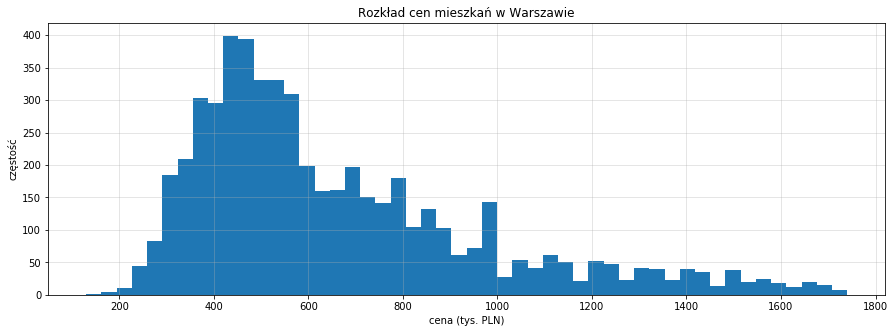

In [20]:
plt.figure(figsize=(15,5))
plt.hist(prices['price'], bins=50)
plt.grid(alpha=0.4)
plt.title('Rozkład cen mieszkań w Warszawie')
plt.xlabel('cena (tys. PLN)')
plt.ylabel('częstość')
plt.show()

Histogram dla zmiennej 'area'

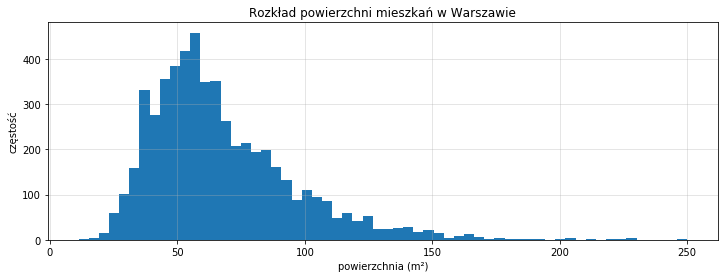

In [21]:
plt.figure(figsize=(12,4))
plt.hist(prices['area'], bins=60)
plt.grid(alpha=0.4)
plt.title('Rozkład powierzchni mieszkań w Warszawie')
plt.xlabel('powierzchnia (m²)')
plt.ylabel('częstość')
plt.show()

Histogram dla zmiennej 'floor'

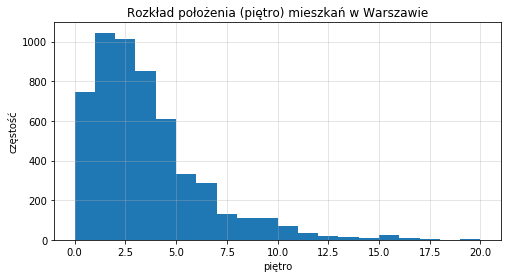

In [22]:
plt.figure(figsize=(8,4))
plt.hist(prices['floor'], bins=20)
plt.grid(alpha=0.4)
plt.title('Rozkład położenia (piętro) mieszkań w Warszawie')
plt.xlabel('piętro')
plt.ylabel('częstość')
plt.show()

<b>Wstępna analiza zależności między zmiennymi</b><br><br>
Występowanie silnej dodatniej korelacji między zmiennymi 'area' i 'price'.

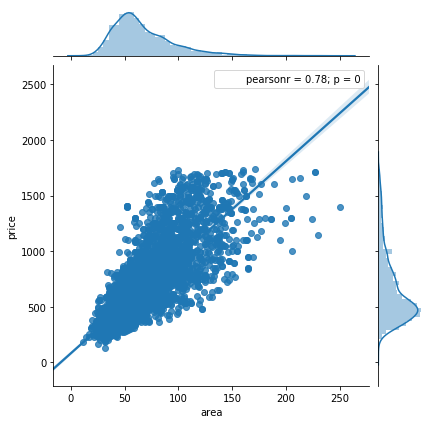

In [23]:
sns.jointplot(data=prices, x='area', y='price', kind='reg', size=6, ratio=6)

Występowanie słabej dodatniej korelacji między zmiennymi 'floor' i 'price'.

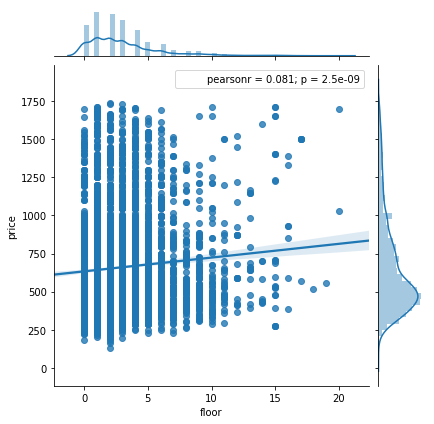

In [24]:
sns.jointplot(data=prices, x='floor', y='price', kind='reg', size=6, ratio=6)

### 4. Modelowanie cen mieszkań

<b>Podział na zbiór uczący i walidacyjny</b>,<br><br>
Zbiór uczący - 80% obserwacji, zbiór testowy - 20% obserwacji.

In [25]:
X = final_data.drop(['price'], axis=1)
y = final_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

<b>Standaryzacja zmiennych 'area' i 'floor' na bazie danych uczących</b>

In [26]:
scaler = StandardScaler()
scaled_predictors = scaler.fit_transform(X_train[['area','floor']])
X_train[['area_sc','floor_sc']] = pd.DataFrame(columns=['area_sc','floor_sc'])
X_train[['area_sc','floor_sc']] = scaled_predictors
X_train.drop(['area','floor'], axis=1, inplace=True)

#### Model 1. Linear Regression
Prosty model regresji liniowej wyjaśnia blisko 75% wariancji zmiennej zależnej. 

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
print('Współczynnik determinacji R^2: {}'.format(lin_reg.score(X_train,y_train).round(3)))

Współczynnik determinacji R^2: 0.747


Pierwiastek błędu średniokwadratowego (Root Mean Square Error) dla zbioru uczącego wynosi ok. 157 tys. PLN.

In [28]:
predictions_lin_reg = lin_reg.predict(X_train)
lin_reg_mse = mean_squared_error(y_train, predictions_lin_reg)
lin_reg_rmse = np.sqrt(lin_reg_mse)
print('Pierwiastek błędu średniokwadratowego (RMSE) dla zbioru uczącego:', lin_reg_rmse.round(1))

Pierwiastek błędu średniokwadratowego (RMSE) dla zbioru uczącego: 157.4


#### Model 2. Linear Regression - z wykorzystaniem kroswalidacji
W celu dokładniejszego oszcowania wyników modelu regresji liniowej zastosowano 10-krotny sprawdzian krzyżowy. Uzyskany średni RMSE jest zbliżony do modelu bez kroswalidacji.  

In [29]:
lin_reg_cv = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
lin_reg_cv_rmse = np.sqrt(-lin_reg_cv)
print('Wyniki 10-krotnego sprawdzianu krzyżowego:', lin_reg_cv_rmse.round(1))
print('Średnia z wyników sprawdzianu krzyżowego:', lin_reg_cv_rmse.mean().round(1))
print('Odchylenie standardowe wyników sprawdzianu krzyżowego:', lin_reg_cv_rmse.std().round(1))

Wyniki 10-krotnego sprawdzianu krzyżowego: [145.8 162.7 166.  145.5 164.3 167.6 149.2 155.7 152.6 168.2]
Średnia z wyników sprawdzianu krzyżowego: 157.8
Odchylenie standardowe wyników sprawdzianu krzyżowego: 8.6


#### Model 3. Decision Tree Regressor - z wykorzystaniem kroswalidacji
Model drzewa decyzyjnego z 10-krotną kroswalidacją cechował się średnio gorszymi wynikami od modelu regresji liniowej (średnia z wyników sprawdzianu krzyżowego ok. 169 tys. PLN).

In [30]:
tree_reg_cv = cross_val_score(DecisionTreeRegressor(), X_train, y_train, scoring='neg_mean_squared_error', cv=10)
tree_reg_cv_rmse = np.sqrt(-tree_reg_cv)
print('Wyniki 10-krotnego sprawdzianu krzyżowego:', tree_reg_cv_rmse.round(1))
print('Średnia z wyników sprawdzianu krzyżowego:', tree_reg_cv_rmse.mean().round(1))
print('Odchylenie standardowe wyników sprawdzianu krzyżowego:', tree_reg_cv_rmse.std().round(1))

Wyniki 10-krotnego sprawdzianu krzyżowego: [168.4 182.7 183.8 175.8 180.3 160.6 154.2 159.  155.7 164.4]
Średnia z wyników sprawdzianu krzyżowego: 168.5
Odchylenie standardowe wyników sprawdzianu krzyżowego: 10.8


#### Model 4. Random Forest Regressor - z wykorzystaniem kroswalidacji
Model losowego lasu cechuje się najlepszymi wynikami w porównaniu z pozostałymi modelami - średnia z wyników sprawdzianu krzyżowego oscyluje wokół wartości 142 tys. PLN. Dlatego też model ten w następnym kroku poddany zostanie optymalizacji hiperparametrów.

In [31]:
forest_reg_cv = cross_val_score(RandomForestRegressor(), X_train, y_train, scoring='neg_mean_squared_error', cv=10)
forest_reg_cv_rmse = np.sqrt(-forest_reg_cv)
print('Wyniki 10-krotnego sprawdzianu krzyżowego:', tree_reg_cv_rmse.round(1))
print('Średnia z wyników sprawdzianu krzyżowego:', forest_reg_cv_rmse.mean().round(1))
print('Odchylenie standardowe wyników sprawdzianu krzyżowego:', forest_reg_cv_rmse.std().round(1))

Wyniki 10-krotnego sprawdzianu krzyżowego: [168.4 182.7 183.8 175.8 180.3 160.6 154.2 159.  155.7 164.4]
Średnia z wyników sprawdzianu krzyżowego: 141.6
Odchylenie standardowe wyników sprawdzianu krzyżowego: 9.4


#### Model 5. Random Forest Regressor - z optymalizacją hiperparametrów metodą RandomizedSearchCV
Parametry poddane optymalizacji to: 'n_estimators' oraz 'bootstrap'. Przetestowano w sumie 50 losowych kombinacji hiperparametrów z 5-krotną kroswalidacją. Optymalizacja modelu pozwoliła znacząco poprawić wyniki w porównaniu do standardowych wartości tych hiperparametrów.

In [32]:
param_grid = {'n_estimators': randint(5,300),
             'bootstrap': ('True', 'False')}

forest_reg = RandomForestRegressor(min_samples_leaf=3)
forest_reg_rscv = RandomizedSearchCV(forest_reg, param_grid, n_iter=50, cv=5, scoring='neg_mean_squared_error')
forest_reg_rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023160FAAA20>, 'bootstrap': ('True', 'False')},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

Optymalne parametry - 'bootstrap': 'True', 'n_estimators': 146

In [34]:
forest_reg_rscv.best_params_

{'bootstrap': 'True', 'n_estimators': 146}

In [35]:
model_final = forest_reg_rscv.best_estimator_

Model wytrenowany na danych uczących wyjaśnia łącznie blisko 91% zmienności zmiennej zależnej.

In [36]:
print('Współczynnik determinacji R^2: {}'.format(model_final.score(X_train, y_train).round(3)))

Współczynnik determinacji R^2: 0.905


Przy optymalnych hiperparametrach pierwiastek błędu średniokwadratowego (RMSE) dla zbioru uczącego wynosi ok 97 tys. PLN.

In [37]:
predictions_model_final = model_final.predict(X_train)
model_final_mse = mean_squared_error(y_train, predictions_model_final)
model_final_rmse = np.sqrt(model_final_mse)
print('Pierwiastek błędu średniokwadratowego (RMSE) dla zbioru uczącego:', model_final_rmse.round(1))

Pierwiastek błędu średniokwadratowego (RMSE) dla zbioru uczącego: 96.6


Określono również względne istotności poszczególnych atrybutów.

In [38]:
feature_importances = model_final.feature_importances_

print('Istotności poszczególnych atrybutów:')
for atrib, importance in zip(X_train.columns, feature_importances):
    print(atrib, ':', importance.round(4))

Istotności poszczególnych atrybutów:
Bemowo : 0.0017
Białołęka : 0.0307
Bielany : 0.0011
Mokotów : 0.0256
Ochota : 0.0043
Praga-Południe : 0.0053
Praga-Północ : 0.001
Rembertów : 0.0006
Targówek : 0.0015
Ursus : 0.0013
Ursynów : 0.0048
Wawer : 0.0093
Wesoła : 0.007
Wilanów : 0.0073
Wola : 0.0083
Włochy : 0.0025
Śródmieście : 0.056
Żoliborz : 0.0085
area_sc : 0.7787
floor_sc : 0.0445


<b>Weryfikacja finalnego modelu na zbiorze walidacyjnym</b><br><br>
Przed przystąpieniem do weryfikacji modelu, konieczna jest standaryzacja zmiennych testowych według parametrów uzyskanych dla zbioru uczącego.

In [39]:
scaled_predictors_test = scaler.transform(X_test[['area','floor']])
X_test[['area_sc','floor_sc']] = pd.DataFrame(columns=['area_sc','floor_sc'])
X_test[['area_sc','floor_sc']] = scaled_predictors_test

X_test.drop(['area','floor'], axis=1, inplace=True)

Walidacja finalnego modelu na zbiorze testowym wskazała RMSE na poziomie ok 132 tys. PLN.

In [40]:
predictions_model_final = model_final.predict(X_test)

In [41]:
model_final_mse = mean_squared_error(y_test, predictions_model_final)
model_final_rmse = np.sqrt(model_final_mse)
print('Pierwiastek błędu średniokwadratowego (RMSE) na zbiorze testowym:', model_final_rmse.round(1))

Pierwiastek błędu średniokwadratowego (RMSE) na zbiorze testowym: 131.7


<b>Przykładowe predykcje</b><br><br>
Przed dokonaniem przykładowej predykcji przy użyciu opracowanego modelu, należy uwzględnić konieczność standaryzacji zmiennych 'area' i 'floor'

In [42]:
# predykcja dla przykładowego mieszkania o powierzchni 75 m.kw, na drugim piętrze, zlokalizowanego na Białołęce 
# wymagana standaryzacja predyktorów 'area' i 'floor'
example_area = 75 # m²
example_floor = 2 

example_predictors_scaled = scaler.transform(np.array([[example_area,example_floor]]))
ex_area_scaled = example_predictors_scaled[0,0]
ex_floor_scaled = example_predictors_scaled[0,1]
print('Wartość zmiennej "area" ({}m²) po standaryzacji: {}'.format(example_area, ex_area_scaled))
print('Wartość zmiennej "floor" ({} piętro) po standaryzacji: {}'.format(example_floor, ex_floor_scaled))

Wartość zmiennej "area" (75m²) po standaryzacji: 0.2763270995537337
Wartość zmiennej "floor" (2 piętro) po standaryzacji: -0.378480938152188


In [43]:
X_test.columns

Index(['Bemowo', 'Białołęka', 'Bielany', 'Mokotów', 'Ochota', 'Praga-Południe',
       'Praga-Północ', 'Rembertów', 'Targówek', 'Ursus', 'Ursynów', 'Wawer',
       'Wesoła', 'Wilanów', 'Wola', 'Włochy', 'Śródmieście', 'Żoliborz',
       'area_sc', 'floor_sc'],
      dtype='object')

Mając standaryzowane dane można dokonać predykcji wartości przykładowego mieszkania o powierzchni 75 m.kw, na drugim piętrze, zlokalizowanego na Białołęce

In [44]:
# predykcja wartości mieszkania
example_flat_prediction = model_final.predict([[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ex_area_scaled,ex_floor_scaled]])
print('Szacowana cena mieszkania: {} tys.PLN'.format(example_flat_prediction.round(2)[0]))

Szacowana cena mieszkania: 529.94 tys.PLN
